# Grad-CAM class activation visualization


Adapted from [keras code examples](https://keras.io/examples/vision/grad_cam/)

## Setup

In [23]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras

# Display
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model

In [24]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [26]:
def escape_fname(name):
    return name.replace('/','_')

def search_folder(folder_id, root):
    MAX_FILE_COUNT = 250
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    # file_list.count
    cnt = 0
    for file in file_list:
        cnt += 1
        if cnt > MAX_FILE_COUNT: #Stop creating files in the local directory if the number of files > MAX_FILE_COUNT
          break
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            prod_cat_foldername = file['title'].split('_')[0]
            prod_cat_folder = create_folder(root, prod_cat_foldername)
            class_foldername = escape_fname(file['title'])
            class_folder = create_folder(prod_cat_folder+'/', class_foldername)
            search_folder(file['id'], class_folder)
        else:
            # download_mimetype = None
            filename = escape_fname(file['title'])
            filename = '{}{}'.format(root+'/', filename)
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def create_folder(path,name):
    folder = '{}{}'.format(path,escape_fname(name))
    if not os.path.isdir(folder):
      print(f"Creating folder: {folder}")
      os.mkdir(folder)
    return folder

# F
def search_processed_datasets_folder(folder_id, root):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    for file in file_list:
        # print('title: %s, id: %s, kind: %s' % (file['title'], file['id'], file['mimeType']))
        # print(file)
        if file['mimeType'].split('.')[-1] == 'folder':
            folder = create_folder(root+'/', file['title'])
            search_processed_datasets_folder(file['id'], root+'/'+file['title'])
        else:
            # download_mimetype = None
            filename = '{}{}'.format(root+'/', file['title'])
            try:
                file.GetContentFile(filename)
            except:
                print('FAILED')
                f.write(filename+'\n')

def get_folder_info(folder_id):
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % folder_id}).GetList()
    print(f'Number of folders/files in folder = {len(file_list)}')
    for file in file_list:
        if file['mimeType'].split('.')[-1] == 'folder':
            print(f"Folder Name = {file['title']}")
            get_folder_info(file['id'])
        else:
            pass


In [27]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

f = open("failed.txt","w+")
# # folder_id = '17NfTjPmDwCB5WO3FgM83Bmgdc631e8Ac' # Folder ID for image_data folder in Best Secrets GDrive (/Best Secret/Data/image_data)
# folder_id = '1Dw7Ae8--BC0I5ROvg36sZB9nZSsGQnyv' # Folder ID for data_not_cleaned folder in Best Secrets GDrive (/Best Secret/Data/data_not_cleaned)
model_folder_id = '1JUgLVKtQinZkC79GIsnu6YwbAESWpntX'

# Note: these folders should match the final project folder structure we create and may need to be updated
# root = './data/raw'
model_root = './models'
# If the folders that we want to download the images to do not exit then create them as shown below:
# if not os.path.isdir("./data"):
#   os.mkdir('./data')

# if not os.path.isdir("./data/raw"):
#   os.mkdir('./data/raw')

if not os.path.isdir("./models"):
  os.mkdir('./models')


search_folder(model_folder_id, model_root+'/')  # search_folder(folder_id,root+'/')
f.close()

## Configurable parameters

You can change these to another model.

To get the values for `last_conv_layer_name` use `model.summary()`
to see the names of all layers in the model.

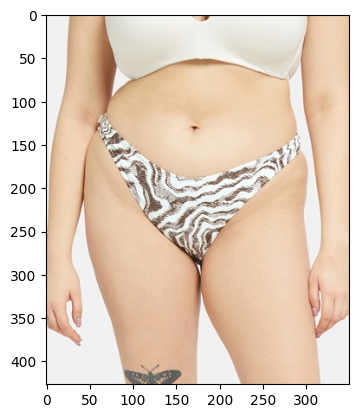

In [126]:
img = plt.imread('/content/32938725-001.jpg')
plt.imshow(img)

## The Grad-CAM algorithm

In [127]:

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


## Let's test-drive it

In [128]:
img = tf.expand_dims(img, 0)

1/1 [==============================] - 0s 19ms/step


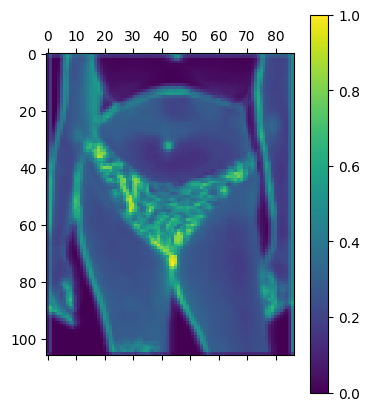

In [129]:
# # Prepare image
# img_array = preprocess_input(get_img_array(img_path, size=img_size))

# # Make model
# model = model_builder(weights="imagenet")

# # Remove last layer's softmax
# model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img)
# print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.colorbar()
plt.show()


## Create a superimposed visualization

In [130]:
img.shape

TensorShape([1, 427, 350, 3])

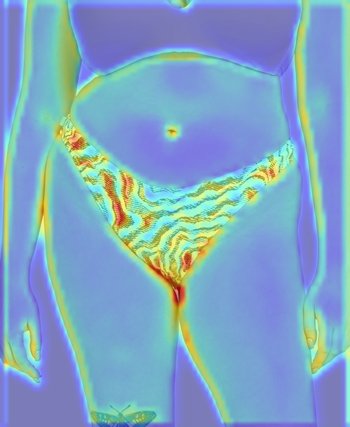

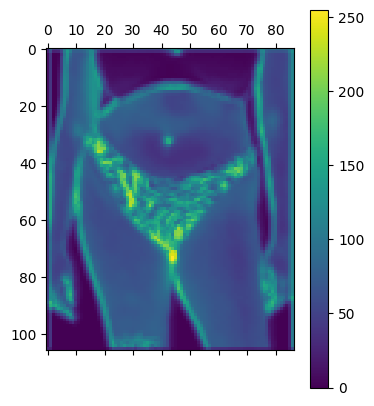

In [131]:
def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.95):
    # # Load the original image
    # img = keras.utils.load_img(img_path)
    img = np.copy(img)
    img = img[0]
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(superimposed_img)

    # Display heatmap
    plt.matshow(heatmap)
    plt.colorbar()
    plt.show()

save_and_display_gradcam(img, heatmap)

## Let's try another image

In [132]:
img_2 = plt.imread('/content/32827743-001.jpg')
# plt.imshow(img_2)

img_2 = tf.expand_dims(img_2, 0)

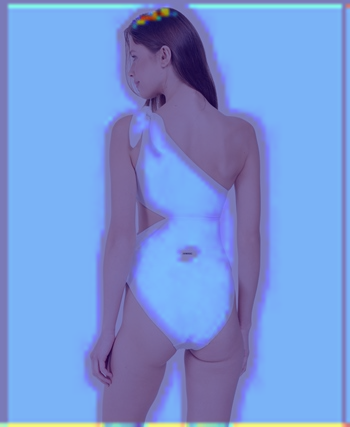

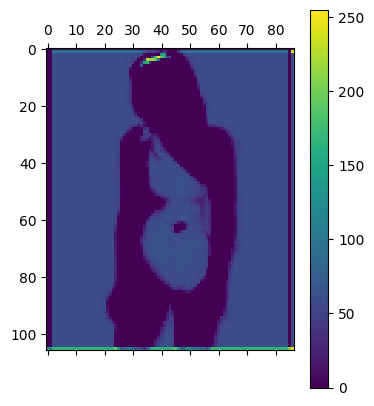

In [133]:
heatmap_2 = make_gradcam_heatmap(img_2, model, last_conv_layer_name)

save_and_display_gradcam(img_2, heatmap_2)

In [134]:
img_3 = plt.imread('/content/32891827-001.jpg')
# plt.imshow(img_3)

img_3 = tf.expand_dims(img_3, 0)

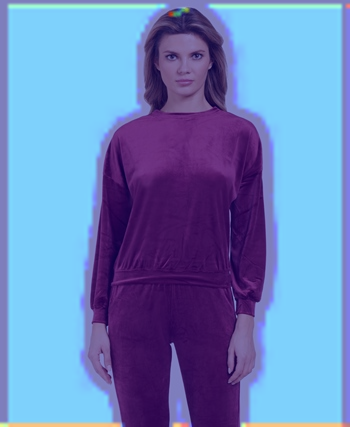

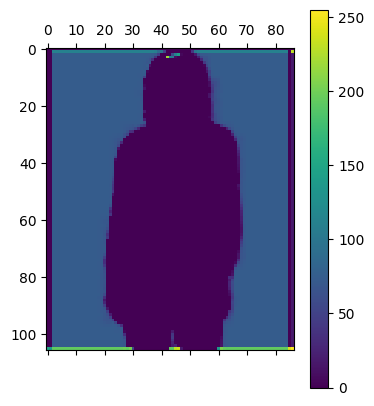

In [135]:
heatmap_3 = make_gradcam_heatmap(img_3, model, last_conv_layer_name)

save_and_display_gradcam(img_3, heatmap_3)